# Pokemon

## Import lib & modules

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

In [2]:
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Load the CSV & Check for GPU

In [3]:
df = pd.read_csv("pokemon.csv")
print(df.head())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

         Name  Type1   Type2   Evolution
0   bulbasaur  Grass  Poison     ivysaur
1     ivysaur  Grass  Poison    venusaur
2    venusaur  Grass  Poison         NaN
3  charmander   Fire     NaN  charmeleon
4  charmeleon   Fire     NaN   charizard


In [4]:
unique_types = sorted(df['Type1'].unique())
num_classes = len(unique_types)
print(f"Unique Types: {unique_types}")
print(f"Number of Classes: {num_classes}")

Unique Types: ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']
Number of Classes: 18


## Custom Dataset

In [5]:
class PokemonDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(sorted(df['Type1'].unique()))}
        self.idx_to_class = {idx: class_name for class_name, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        name = row['Name']
        label = row['Type1']

        img_path = os.path.join(self.img_dir, f"{name.capitalize()}.png")
        
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image not found: {img_path}. Skipping this sample.")
            return None, None  
        
        if self.transform:
            image = self.transform(image)
        
        label_idx = self.class_to_idx[label]
        return image, label_idx

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Type1'])

img_dir = "images"
full_train_dataset = PokemonDataset(train_df, img_dir, transform=transform_train)
full_test_dataset = PokemonDataset(test_df, img_dir, transform=transform_test)

train_dataset = [(img, lbl) for img, lbl in full_train_dataset if img is not None]
test_dataset = [(img, lbl) for img, lbl in full_test_dataset if img is not None]

def collate_fn(batch):
    batch = [item for item in batch if item[0] is not None]
    if len(batch) == 0:
        return None, None
    return torch.utils.data.dataloader.default_collate(batch)

## Data loaders, Pre-Trained Model & Optimizer

In [7]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Training loop

In [8]:
num_epochs = 25
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch in train_loader:
        if batch[0] is None:
            continue
        inputs, labels = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total if total > 0 else 0
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), "pokemon_model_best.pth")


Epoch 1/25, Loss: 2.8012, Accuracy: 0.1793
Epoch 2/25, Loss: 2.3030, Accuracy: 0.3045
Epoch 3/25, Loss: 2.2146, Accuracy: 0.3292
Epoch 4/25, Loss: 1.9971, Accuracy: 0.3941
Epoch 5/25, Loss: 1.5698, Accuracy: 0.4915
Epoch 6/25, Loss: 1.1018, Accuracy: 0.6569
Epoch 7/25, Loss: 0.8399, Accuracy: 0.7450
Epoch 8/25, Loss: 0.3917, Accuracy: 0.9181
Epoch 9/25, Loss: 0.1640, Accuracy: 0.9830
Epoch 10/25, Loss: 0.1130, Accuracy: 0.9938
Epoch 11/25, Loss: 0.1033, Accuracy: 0.9969
Epoch 12/25, Loss: 0.0698, Accuracy: 0.9954
Epoch 13/25, Loss: 0.0563, Accuracy: 0.9969
Epoch 14/25, Loss: 0.0557, Accuracy: 0.9969
Epoch 15/25, Loss: 0.0514, Accuracy: 0.9954
Epoch 16/25, Loss: 0.0488, Accuracy: 0.9985
Epoch 17/25, Loss: 0.0570, Accuracy: 0.9954
Epoch 18/25, Loss: 0.0490, Accuracy: 0.9969
Epoch 19/25, Loss: 0.0411, Accuracy: 0.9969
Epoch 20/25, Loss: 0.0414, Accuracy: 0.9985
Epoch 21/25, Loss: 0.0471, Accuracy: 0.9985
Epoch 22/25, Loss: 0.0463, Accuracy: 0.9969
Epoch 23/25, Loss: 0.0472, Accuracy: 0.99

## Evaluation

In [9]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        if batch[0] is None:
            continue
        inputs, labels = batch[0].to(device), batch[1].to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix & Classification Report

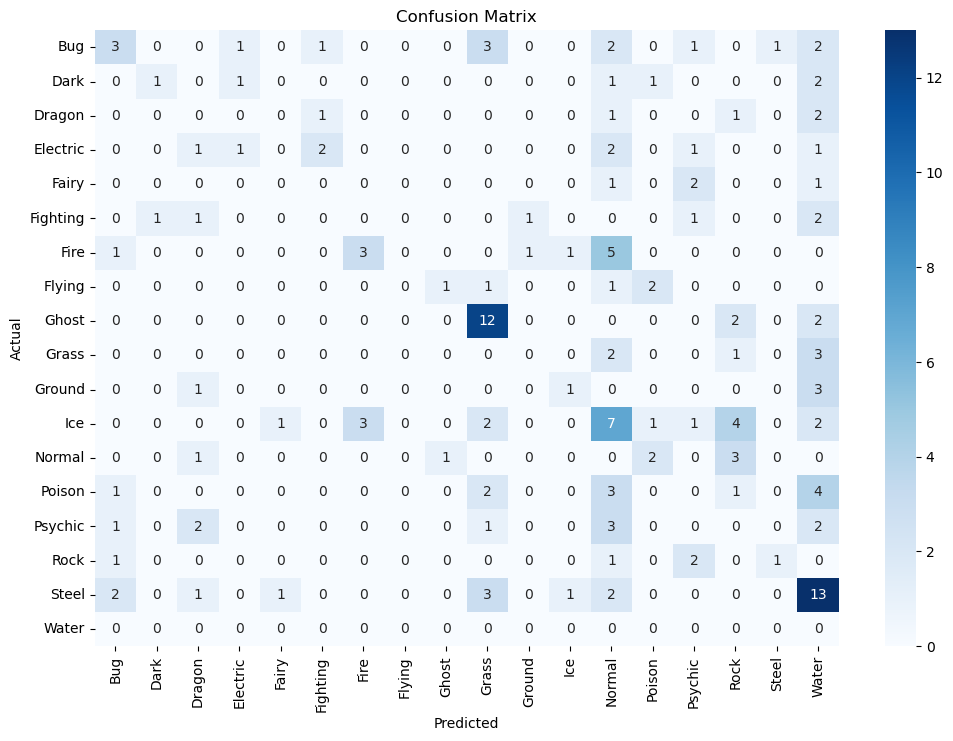

              precision    recall  f1-score   support

         Bug       0.33      0.21      0.26        14
        Dark       0.50      0.17      0.25         6
      Dragon       0.00      0.00      0.00         5
    Electric       0.33      0.12      0.18         8
       Fairy       0.00      0.00      0.00         4
    Fighting       0.00      0.00      0.00         6
        Fire       0.50      0.27      0.35        11
      Flying       0.00      0.00      0.00         5
       Ghost       0.00      0.00      0.00        16
       Grass       0.00      0.00      0.00         6
      Ground       0.00      0.00      0.00         5
         Ice       0.00      0.00      0.00        21
      Normal       0.00      0.00      0.00         7
      Poison       0.00      0.00      0.00        11
     Psychic       0.00      0.00      0.00         9
        Rock       0.00      0.00      0.00         5
       Steel       0.00      0.00      0.00        23
       Water       0.00    

In [10]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_types, yticklabels=unique_types)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(all_labels, all_preds, target_names=unique_types))
torch.save(model.state_dict(), "pokemon_model_improved.pth")

# Prediction function & Example prediction

In [14]:
def predict_image(image_path, model, transform, idx_to_class):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    class_name = idx_to_class[predicted.item()]
    return class_name

idx_to_class = full_train_dataset.idx_to_class  
example_image = "images/abra.png"
predicted_type = predict_image(example_image, model, transform_test, idx_to_class)
print(f"Predicted type for {example_image}: {predicted_type}")

Predicted type for images/abra.png: Psychic
